In [9]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

### Reading train dataset

In [10]:
# load the provided data
train_features = pd.read_csv('dataset/dengue_features_train.csv',
                             index_col=[0,1,2])

train_labels = pd.read_csv('dataset/dengue_labels_train.csv',
                           index_col=[0,1,2])

### Seperating into two cities

In [11]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [12]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


### Remove week_start_date

In [13]:
# Remove `week_start_date` string.
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)

### Check null values

In [14]:
# Null check
pd.isnull(sj_train_features).any()

ndvi_ne                                  True
ndvi_nw                                  True
ndvi_se                                  True
ndvi_sw                                  True
precipitation_amt_mm                     True
reanalysis_air_temp_k                    True
reanalysis_avg_temp_k                    True
reanalysis_dew_point_temp_k              True
reanalysis_max_air_temp_k                True
reanalysis_min_air_temp_k                True
reanalysis_precip_amt_kg_per_m2          True
reanalysis_relative_humidity_percent     True
reanalysis_sat_precip_amt_mm             True
reanalysis_specific_humidity_g_per_kg    True
reanalysis_tdtr_k                        True
station_avg_temp_c                       True
station_diur_temp_rng_c                  True
station_max_temp_c                       True
station_min_temp_c                       True
station_precip_mm                        True
dtype: bool

### Variation of total_cases with a selected feature

Text(0,0.5,u'station_avg_temp_c')

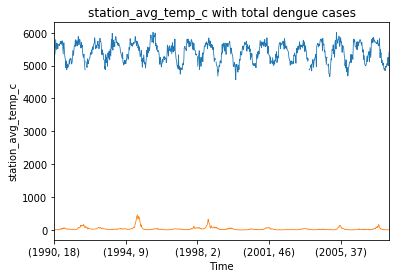

In [15]:
variable = "station_avg_temp_c"

((sj_train_features
     .station_avg_temp_c * 200)
     .plot
     .line(lw=0.8))

((sj_train_labels
     .total_cases)
     .plot
     .line(lw=0.8))


plt.title(variable + ' with total dengue cases')
plt.xlabel('Time')
plt.ylabel(variable)

### Filling null values - 'ffill'

In [16]:
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

In [17]:
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  34.1805555556
var : 2640.04543969

Iquitos
mean:  7.56538461538
var : 115.895523937


### Histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9cfcadf250>]], dtype=object)

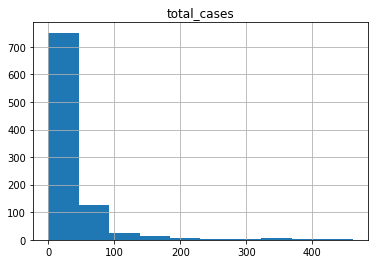

In [18]:
sj_train_labels.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9cc5e369d0>]], dtype=object)

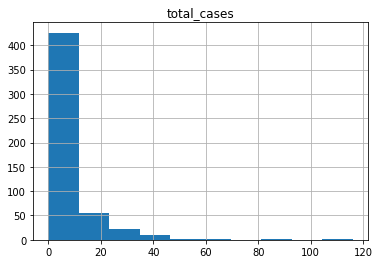

In [19]:
iq_train_labels.hist()

In [20]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

### Correlation Analysis

In [21]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

Text(0.5,1,u'San Juan Variable Correlations')

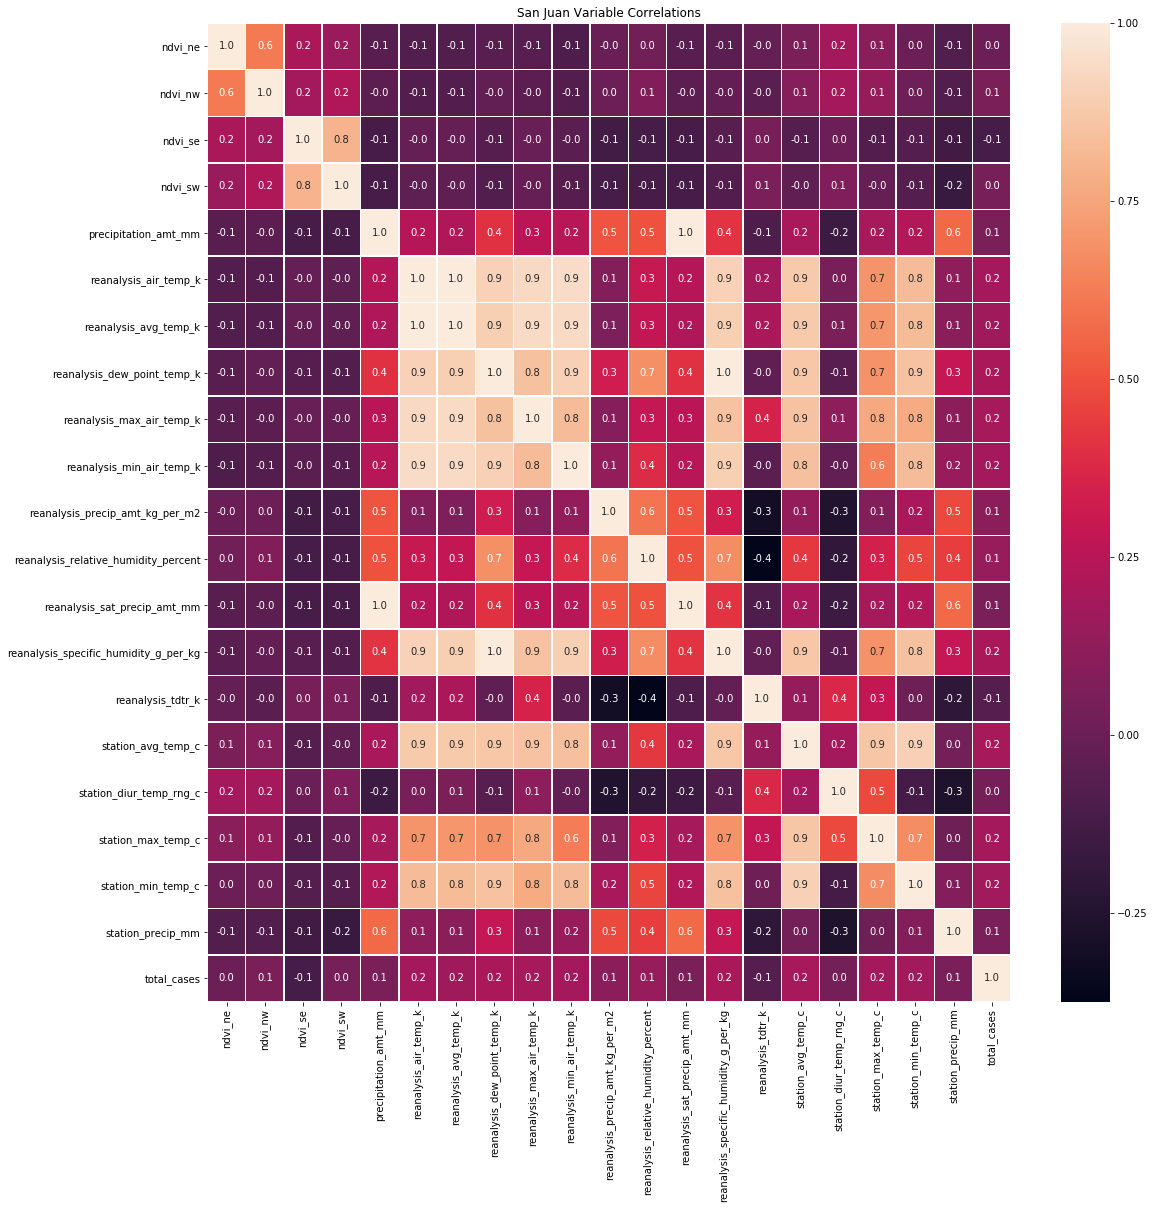

In [22]:
# plot san juan
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(sj_correlations, annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('San Juan Variable Correlations')

Text(0.5,1,u'iquitos Variable Correlations')

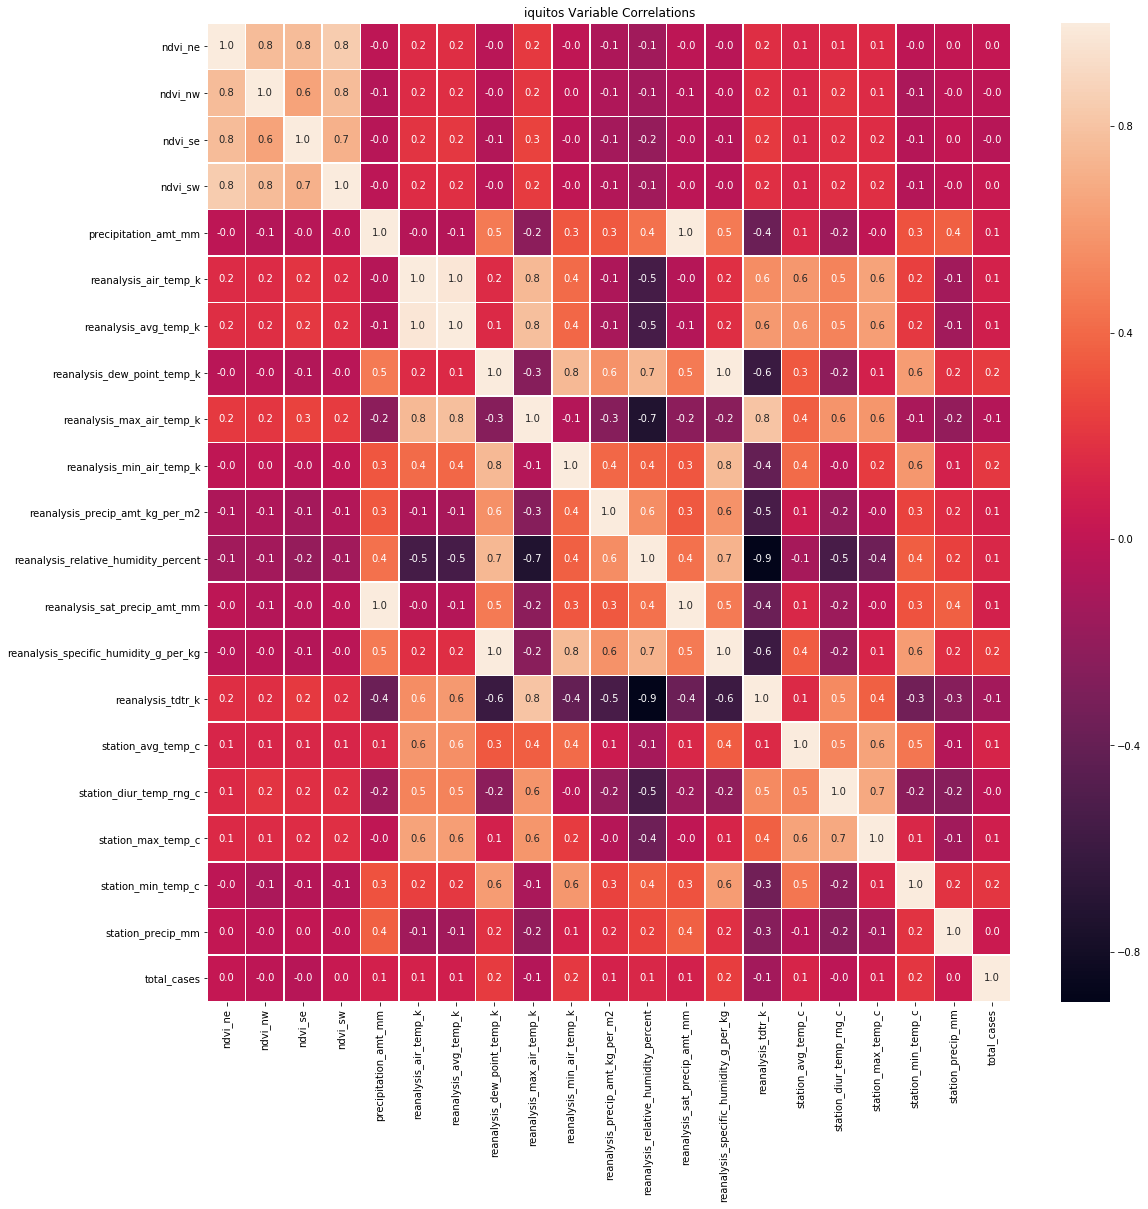

In [23]:
# plot iquitos
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(iq_correlations, annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('iquitos Variable Correlations')

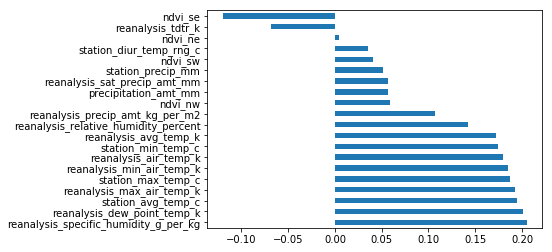

In [24]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

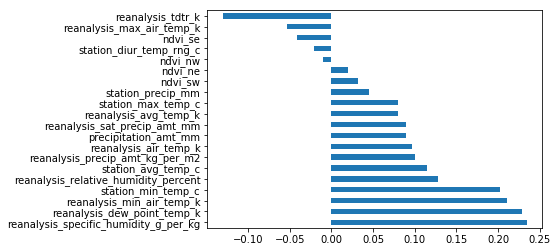

In [25]:
# iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

## Seperate feature selection for two cities

In [26]:
#preprocess data for san juan
def sj_preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'reanalysis_max_air_temp_k']
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan
    sj = df.loc['sj']
    
    return sj

In [27]:
#to preprocess iq data
def iq_preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_min_temp_c', 
                 'reanalysis_tdtr_k']
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate iquitos
    iq = df.loc['iq']
    
    return iq

In [28]:
sj_train = sj_preprocess_data('dataset/dengue_features_train.csv',labels_path="dataset/dengue_labels_train.csv")
iq_train = iq_preprocess_data('dataset/dengue_features_train.csv',labels_path="dataset/dengue_labels_train.csv")

In [29]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

## Seperate Model Selection for two cities

In [30]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

def get_best_model_sj(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_avg_temp_c + " \
                    "reanalysis_max_air_temp_k"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

In [31]:
def get_best_model_iq(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "reanalysis_tdtr_k"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

In [32]:
sj_best_model = get_best_model_sj(sj_train_subtrain, sj_train_subtest)

best alpha =  1e-08
best score =  22.8529411765


In [33]:
iq_best_model = get_best_model_iq(iq_train_subtrain, iq_train_subtest)

best alpha =  1e-08
best score =  6.43333333333


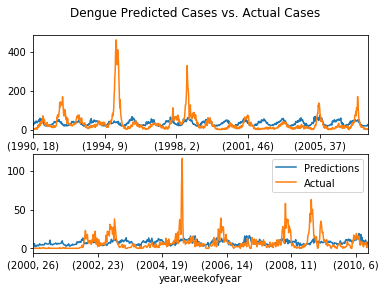

In [34]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [35]:
sj_test = sj_preprocess_data('dataset/dengue_features_test.csv')
iq_test = iq_preprocess_data('dataset/dengue_features_test.csv')

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv("dataset/submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("results/negative_binomial_seperate_features_model_selection.csv")